In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten
from tensorflow_docs import modeling
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
import sklearn.metrics
import io
import itertools

In [2]:
# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
log_dir = pathlib.Path('logs/fit')
shutil.rmtree(log_dir, ignore_errors=True)
log_dir

%load_ext tensorboard

In [3]:
tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE
print("Number of GPU available: ",len(tf.config.experimental.list_physical_devices("GPU")))
tf.__version__

Number of GPU available:  2


'2.1.0'

In [4]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return tf.reshape(tf.where(parts[-2] == CLASS_NAMES),[])

In [5]:
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [6]:
def augment(image,label):
  image = tf.image.random_hue(image, max_delta=0.05, seed=5)
  image = tf.image.random_contrast(image, 0.9, 1.1, seed=5) # tissue quality
  image = tf.image.random_saturation(image, 0.9, 1.1, seed=5) # stain quality
  image = tf.image.random_brightness(image, max_delta=0.1) # tissue thickness, glass transparency (clean)
  image = tf.image.random_flip_left_right(image,seed=5) # cell orientation
  image = tf.image.random_flip_up_down(image, seed=5) # cell orientation
  image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) # cell orientation
  return image,label

In [7]:
def process_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
IMG_HEIGHT = 100
IMG_WIDTH = 100

<h1> Loading the dataset </h1>

How to use tensorflow dataset API
Use list-comprehension to find all image files in the folder


In [9]:
data_dir=r'C:\Users\kuki\Desktop\Skin\TensorData\train'
data_dir = pathlib.Path(data_dir)
train_image_count = len(list(data_dir.glob('*\*.jpg')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_store"])
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [10]:
BATCH_SIZE = 32 
STEPS_PER_EPOCH = train_image_count//BATCH_SIZE

In [11]:
N_VALIDATION=1000
VALIDATION_STEPS = N_VALIDATION // BATCH_SIZE
val_ds= (labeled_ds
               .take(N_VALIDATION)
               .cache("./fibro_val.tfcache")
               .repeat()
               .batch(BATCH_SIZE)
               .prefetch(buffer_size=AUTOTUNE))

shuffle_buffer_size = 100 # affect randomness of dataset. it will take first 100 from dataset and shuffle and pick one.
train_ds = (labeled_ds
            .skip(N_VALIDATION)
            .cache("./fibro_train.tfcache")
            .shuffle(buffer_size=shuffle_buffer_size)
            .repeat()
            .map(augment, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )

In [12]:
# no shuffle, no augment
test_data_dir=r'C:\Users\kuki\Desktop\Skin\TensorData\test'
test_data_dir = pathlib.Path(test_data_dir)
test_image_count = len(list(test_data_dir.glob('*\*.jpg')))
TEST_STEPS = test_image_count // BATCH_SIZE
test_list_ds = tf.data.Dataset.list_files(str(test_data_dir/'*/*'))
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = (test_labeled_ds
            .cache("./fibro_test.tfcache")
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE) #time it takes to produce next element
            )
TEST_STEPS

12

In [13]:
#relu, leaky_relu, elu
model_cnnA1= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2) #young vs old
])

In [14]:
model_cnnA2= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])

In [15]:
# Regularization detail on L2, dropout, Early stopping, Data augmentation
# https://www.deeplearningbook.org/contents/regularization.html
model_cnnA3= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])

In [16]:
model_cnnA4= Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])


In [17]:
lr_schedule = optimizers.schedules.InverseTimeDecay(
  0.0001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
shutil.rmtree(checkpoint_dir, ignore_errors=True)

# file_writer = tf.summary.create_file_writer(log_dir/"metrics")
# file_writer.set_as_default()

def get_optimizer():
  return optimizers.Adam(lr_schedule)

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    self.model.reset_metrics()


def get_callbacks(name):
  return [
    modeling.EpochDots(),
    CollectBatchStats(),
    tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_crossentropy',
                                     patience=100,restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir/name, histogram_freq=1),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       verbose=0,
                                       monitor='val_sparse_categorical_crossentropy',
                                       save_weights_only=True,
                                       save_best_only=True),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',
    #                                      factor=0.1, patience=10, verbose=0, mode='auto',
    #                                      min_delta=0.0001, cooldown=0, min_lr=0),
  ]

In [19]:
def compilefit(model,loss_fn, name, optimizer=None, max_epochs=10):
    if optimizer is None: optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[
                  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  'accuracy'])
    model.summary()
    history = model.fit(train_ds,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=max_epochs,
          verbose=0,
          validation_data=val_ds,
          callbacks=get_callbacks(name),
          validation_steps=VALIDATION_STEPS,
          use_multiprocessing=True)
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    model.save(pathlib.Path(name)/'full_model.h5')
    return history

In [20]:
%tensorboard --logdir log_dir
histories={}
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Reusing TensorBoard on port 6006 (pid 2896), started 1:52:39 ago. (Use '!kill 2896' to kill it.)

In [21]:
histories['cnnA1'] = compilefit(model_cnnA1,loss_fn,'cnn/A1')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

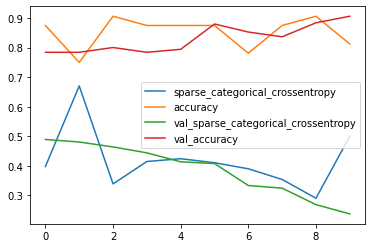

In [22]:
dfobj = histories['cnnA1'].history
dfobj.pop('loss')
dfobj.pop('val_loss')
pd.DataFrame(dfobj).plot()

#loss and accuracy decrease -> overfitting
#loss increase and accuracy decrease -> regularization works only if loss starts to decrease eventually

In [23]:
def compilefit(model,loss_fn, name, optimizer=None, max_epochs=10):
    if optimizer is None: optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[
                  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  'accuracy'])
    model.summary()
    history = model.fit(train_ds,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=max_epochs,
          verbose=0,
          validation_data=test_ds,
          callbacks=get_callbacks(name),
          validation_steps=TEST_STEPS,
          use_multiprocessing=True)
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    model.save(pathlib.Path(name)/'full_model.h5')
    return history

In [24]:
histories={}
histories['cnnA1'] = compilefit(model_cnnA1,loss_fn,'cnn/A1')
histories['cnnA2'] = compilefit(model_cnnA2,loss_fn,'cnn/A2')
histories['cnnA3'] = compilefit(model_cnnA3,loss_fn,'cnn/A3')
histories['cnnA4'] = compilefit(model_cnnA4,loss_fn,'cnn/A4')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

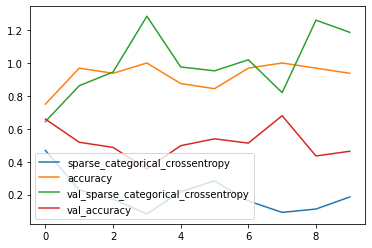

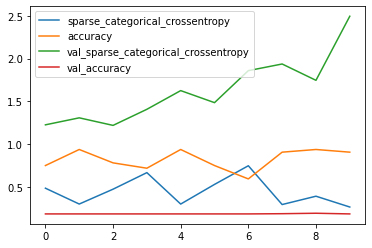

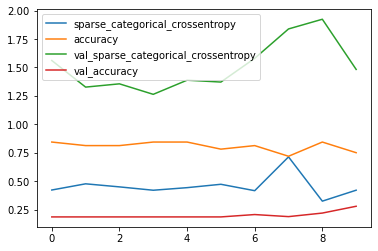

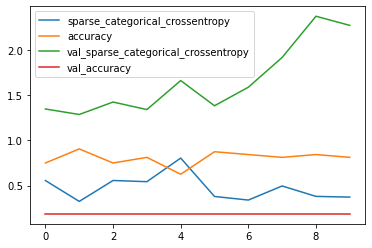

In [25]:
def plotdf(dfobj):
    dfobj.pop('loss')
    dfobj.pop('val_loss')
    pd.DataFrame(dfobj).plot()

plotdf(histories['cnnA1'].history)
plotdf(histories['cnnA2'].history)
plotdf(histories['cnnA3'].history)
plotdf(histories['cnnA4'].history)

In [26]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=None, cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():
    model= Sequential([
    Conv2D(32, (3, 3), activation='elu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='elu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='elu'),
    Dense(2)
    ])

    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

history = model.fit(train_ds,
      steps_per_epoch= STEPS_PER_EPOCH,
      epochs=10,
      verbose=0,
      validation_data=test_ds,
      validation_steps=VALIDATION_STEPS,
      use_multiprocessing=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/dev

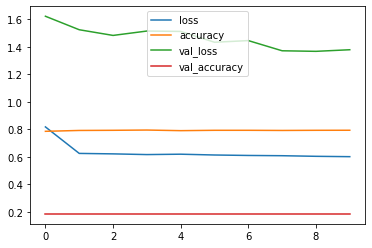

In [27]:
pd.DataFrame(history.history).plot()

In [28]:
classifier_url ='https://tfhub.dev/google/efficientnet/b0/classification/1'
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"
module_spec = hub.load_module_spec(classifier_url)
height, width = hub.get_expected_image_size(module_spec)

# classifier = Sequential([
#     hub.KerasLayer(classifier_url, input_shape=(224,224,3))
# ])

feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(100,100,3))
feature_extractor_layer.trainable = False
model = Sequential([
  feature_extractor_layer,
  Dense(2)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [29]:
model.compile(
  optimizer=optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
batch_stats_callback=CollectBatchStats()
history = model.fit(train_ds, epochs=5,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks = [batch_stats_callback])

Train for 85 steps
Epoch 1/5
85/85 [==============================] - 4s 48ms/step - loss: 0.3004 - accuracy: 0.2812
Epoch 2/5
85/85 [==============================] - 1s 16ms/step - loss: 0.2960 - accuracy: 0.3750
Epoch 3/5
85/85 [==============================] - 1s 16ms/step - loss: 0.2969 - accuracy: 0.5000
Epoch 4/5
85/85 [==============================] - 1s 16ms/step - loss: 0.2936 - accuracy: 0.3438
Epoch 5/5
85/85 [==============================] - 1s 15ms/step - loss: 0.2954 - accuracy: 0.4688


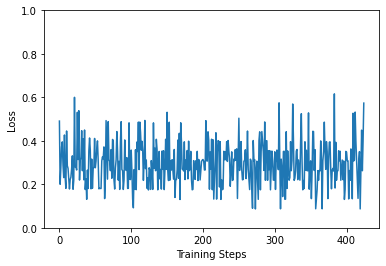

In [30]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_losses)

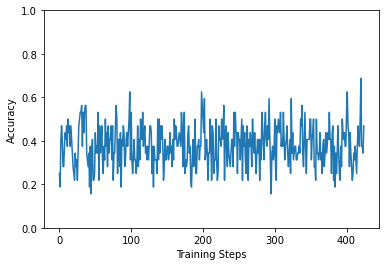

In [31]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

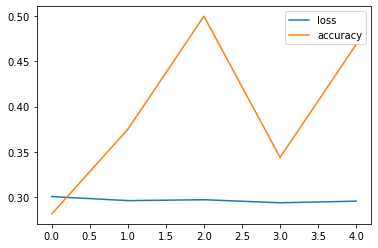

In [32]:
pd.DataFrame(history.history).plot()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

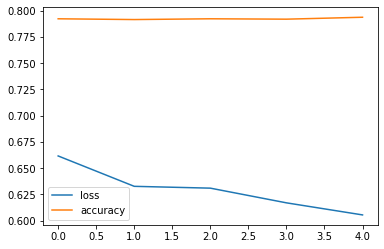

In [33]:
# Xception 299x299
# MobileNetV2 = 224x224
# InceptionResNetV2 = 299x299
base_model = tf.keras.applications.Xception(input_shape=(100,100,3),
                                            include_top=False,
                                            weights=None,
                                            pooling='avg'
                                            )
base_model.trainable = True
Xception = tf.keras.Sequential([
  base_model,
  Dense(2)
])


In [42]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
fine_tune_epochs = 10
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         steps_per_epoch= STEPS_PER_EPOCH,
                         validation_data=val_ds,
                         validation_steps=VALIDATION_STEPS,)

                         
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

Number of layers in the base model:  132
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 9,480,393
Non-trainable params: 11,383,136
_________________________________________________________________
Train for 85 steps, validate for 31 steps
Epoch 5/20
85/85 [==============================] - 43s 500ms/step - loss: 0.5625 - accuracy: 0.7915 - val_loss: 0.5895 - val_accuracy: 0.7843
Epoch 6/20
85/85 [==============================] - 43s 505ms/step - loss: 0.5043 - accuracy: 0.7949 - val_loss: 0.6217 - val_accuracy: 0.

KeyError: 'val_accuracy'

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()